# About Resources

In [1]:
!cat /proc/uptime | awk '{print $1 /60 " mins (" $1 "sec)"}'

333.745 mins (20024.72sec)


In [2]:
!cat /etc/issue

Ubuntu 18.04.1 LTS \n \l



In [0]:
!df -h

In [0]:
!free -h

In [0]:
!cat /proc/cpuinfo

In [0]:
!nvidia-smi

# Connecting to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
!ls

In [0]:
!ls millionlive_idol_prediction/

# Settings

In [4]:
!python --version

Python 3.6.7


In [0]:
%config inlineBackend.figure_format = 'retina'

# Training

In [47]:
import torch
import sys, os.path, glob, json
from collections import OrderedDict
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

root_dir = './millionlive_idol_prediction/'
idol_script_file = root_dir + 'millionlive_idol_script.csv'
tmp_dir = root_dir + 'tmp/'

max_length = 110
batch_size = 100

class MillionLiveIdolScriptsDataset(Dataset):
    """
    Script dataset of THE IDOLM@STER MILLION LIVE! idols.

    Args:
            csv_file (string): Path to the csv file which contains scripts per an idol.
    """
    
    def __init__(self, csv_file=idol_script_file, transform=None):
        self.idol_data_frame = pd.read_csv(csv_file)
        self.transform = transform

        print(self.idol_data_frame)

    def __len__(self):         
        return len(self.idol_data_frame)
        
    def __getitem__(self, idx):
        _id = self.idol_data_frame.iat[idx, 0] # Integer
        _idol_id = self.idol_data_frame.iat[idx, 1]
        _script = self.idol_data_frame.iat[idx, 2]

        if self.transform:
            _id, _idol_id, _script = self.transform(_id, _idol_id, _script)

        return _id, _idol_id, _script

class StringToTensor(object):
    """
    Convert the id in sample to Tensors.
    Then turn the script in sample into Unicode code points and convert it to Tensors.
    """

    def __init__(self, max_length):
        self.max_length = max_length
    
    def __string_to_codepoint(self, _str):
        _encoded_str = [ord(_x) for _x in str(_str).strip()]
        # Return an encoded string as an array like below.
        # [12450, 12452, 12489, 12523, 12395, 12394, 12387, 12390, 12289, 31169, 12398, 22818, 12395, 33394, 12364, 12388, 12365, 12414, 12375, 12383, 12290, 20449, 12376, 12390, 27497, 12365, 32154, 12369, 12390, 12356, 12428, 12400, 12289, 12365, 12387, 12392, 12289, 12356, 12388, 12363, 8230, 12290, 12503, 12525, 12487, 12517, 12540, 12469, 12540, 12290, 31169, 12289, 32118, 23550, 12395, 23626, 12369, 12390, 12415, 12379, 12414, 12377, 12397, 65281]
        _encoded_str = _encoded_str[:self.max_length]
        _str_len = len(str(_str)) # String length
        if _str_len < self.max_length: # If string length is less than a num of max_length, do zero padding
            _encoded_str += ([0] * (self.max_length - _str_len))
        
        return _encoded_str

    def __call__(self, _id, _idol_id, _script):
        
        _script = self.__string_to_codepoint(_script)

        return _id, _idol_id, torch.tensor(_script, dtype=torch.long)
    
class CLCNN(nn.Module):
    def __init__(self, embed_size=512, filter_sizes=(2, 3, 4, 5), filter_num=1500, max_length=max_length):
        super(CLCNN, self).__init__() # Call a method of super class.
        self.filter_sizes = filter_sizes
        self.filter_num = filter_num
        
        self.emb = nn.Embedding(0xffff, embed_size, padding_idx=0) # Get only kinds of three-byte characters of UTF-8
        
        # Convolution layer
        self.conv0 = nn.Sequential(
            nn.Conv2d(1, filter_num, (filter_sizes[0], embed_size)),
            nn.ReLU(),
            nn.MaxPool2d((max_length - filter_sizes[0] + 1, 1))
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, filter_num, (filter_sizes[1], embed_size)),
            nn.ReLU(),
            nn.MaxPool2d((max_length - filter_sizes[1] + 1, 1))
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, filter_num, (filter_sizes[2], embed_size)),
            nn.ReLU(),
            nn.MaxPool2d((max_length - filter_sizes[2] + 1, 1))
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(1, filter_num, (filter_sizes[3], embed_size)),
            nn.ReLU(),
            nn.MaxPool2d((max_length - filter_sizes[3] + 1, 1))
        )
        
        # Fully connected layer
        self.dense = nn.Sequential(
            nn.Linear(filter_num * len(self.filter_sizes), 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 50),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        #print('input:', x.size())
        out = self.emb(x)
        #print('emb:', out.size())
        emb_out = out.unsqueeze(1) # Insert a dimension
        #print('emb_ex:', emb_out.size())

        concat_out = torch.cat((self.conv0(emb_out), self.conv1(emb_out), self.conv2(emb_out), self.conv3(emb_out)), 1)
        #print('concatnated:', concat_out.size())
        out = concat_out.view(-1, self.filter_num * len(self.filter_sizes))
        #print('flatten:', out.size())
        out = self.dense(out)
        #print('output:', out.size())
        
        return out
        
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (labels, idol_ids, scripts)  in enumerate(train_loader):
        labels = labels.to(device)
        scripts = scripts.to(device)

        optimizer.zero_grad()
        outputs = model(scripts)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    train_loss = running_loss / len(train_loader)

    return train_loss

def valid(model, optimizer, criterion, test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (labels, idol_ids, scripts)  in enumerate(test_loader):
            labels = labels.to(device)
            scripts = scripts.to(device)

            outputs = model(scripts)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = outputs.max(1, keepdim=True)[1] # Get the index of the max log-probability
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            total += labels.size(0) # Dim 0 is Batch size
    
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total

    return val_loss, val_acc

def fit(model, optimizer, criterion, train_loader, test_loader, learning_rate, num_epochs):
    loss_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):
        loss = train(model, optimizer, criterion, train_loader)
        val_loss, val_acc = valid(model, optimizer, criterion, test_loader)

        print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss, val_loss, val_acc))

        # Logging
        loss_list.append(loss)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
    print('Finished training.')
    
    # Save the trained model
    #np.save('loss_list.npy', np.array(loss_list))
    #np.save('val_loss_list.npy', np.array(val_loss_list))
    #np.save('val_acc_list.npy', np.array(val_acc_list))
    torch.save(model.state_dict(), root_dir + 'clcnn.pkl')
    
    return loss_list, val_loss_list, val_acc_list

def plot_history(loss_list, val_loss_list, val_acc_list):
    # Plot loss curve
    display('Model Loss')
    plt.plot(loss_list,".-",label="loss",)
    plt.plot(val_loss_list,".-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Plot accurancy curve
    display('Model Acc')
    #plt.plot(history.history['acc'],".-",label="accuracy")
    plt.plot(val_acc_list,".-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

def result_report(model, test_loader):
    global idol_dict
    # Classification Report
    y_true = []
    y_pred = []
    for i, (y, z, x) in enumerate(test_loader):
        y = y.to(device)
        x = x.to(device)

        with torch.no_grad():
            output = model(x)
        y_pred += [idol_dict[int(l.argmax())] for l in output]
        y_true += [idol_dict[int(l)] for l in y]

    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 18)) 
    labels = [idol_dict[i] for i in range(len(idol_dict))]
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    cmx_df = pd.DataFrame(cmx_data, index=labels, columns=labels)
    sns.heatmap(cmx_df, square=True, annot=True, cmap='Blues')
    plt.savefig(root_dir + 'cmx.png')

Device: cuda


In [48]:
# Million Live Idol Scripts Dataset (Scripts and Labels)
transformed_script_dataset = MillionLiveIdolScriptsDataset(transform=StringToTensor(max_length))
# Split dataset
train_data, test_data = train_test_split(transformed_script_dataset, test_size=0.25)
# Dataset Loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=10)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=10)

"""
for i_batch, (id, idol_id, script)  in enumerate(train_loader):
    print('index:', i_batch)
    print('id:', id.size())
    print('idol_id:', idol_id)
    print('script:', script.size())
"""
learning_rate = 0.0001
num_epochs = 100

# Create model
model = CLCNN(max_length=max_length).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print(model)

# Generate an idol dictionary
idol_df = transformed_script_dataset.idol_data_frame.set_index('id')
idol_dict = idol_df['idol_id'].drop_duplicates().to_dict()

# Fit
loss_list, val_loss_list, val_acc_list = fit(model, optimizer, criterion, train_loader, test_loader, learning_rate, num_epochs)

      id idol_id                                             script
0      0  haruka                 トップアイドル目指して、歌も踊りも頑張ります！よろしくお願いします♪
1      0  haruka                               お仕事、頑張るぞー！なーんて、えへへ…。
2      0  haruka                                   張り切っていっちゃいましょうっ！
3      0  haruka                      あの、クッキー焼いてきたんですけど、食べてもらえますか…？
4      0  haruka                              プロデューサーさん、いつもお疲れさまです♪
5      0  haruka                          いたたた…。うう、事務所の前で転んじゃいました…。
6      0  haruka                             えへへっ。私、すっごくワクワクしてきました！
7      0  haruka                             よろしくお願いします、プロデューサーさんっ！
8      0  haruka            ふわあぁ～…っ！あっ、す、すみません！恥ずかしいところ、見られちゃいました…。
9      0  haruka  私を応援してくれてるファンの人って、どのぐらいいるのかなぁ…。プロデューサーさん、気になりま...
10     0  haruka      昨日、劇場のみんなとカラオケに行ってきたんです！プロデューサーさんも来ればよかったのに～。
11     0  haruka                       プロデューサーさんとなら私、どこまでも頑張れそうですっ！
12     0  haruka  プロデューサーさん、ケーキとクッキーだったらどっちが好きですか？…あ、えっとその、今後の参考...
13     0  haruka   プロデューサーさん、私、まだまだ満足したくないですっ！もっ

## Model Loss and Model Accuracy

'Model Loss'

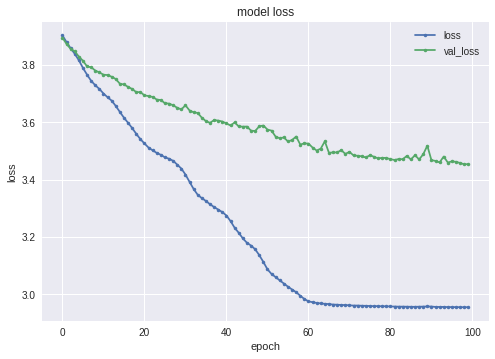

'Model Acc'

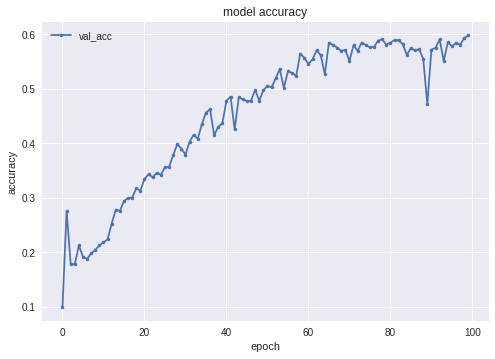

In [49]:
plot_history(loss_list, val_loss_list, val_acc_list)

## Evaluation

              precision    recall  f1-score   support

       akane       0.87      0.85      0.86        40
         ami       0.54      0.65      0.59        40
        anna       0.85      0.81      0.83        48
       arisa       0.90      0.70      0.79        37
       ayumu       0.42      0.39      0.40        44
       azusa       0.33      0.15      0.21        54
     chihaya       0.35      0.32      0.34        53
     chizuru       0.91      0.86      0.89        36
       elena       1.00      0.97      0.99        34
       emily       0.96      0.71      0.82        35
      haruka       0.28      0.40      0.33        45
      hibiki       0.76      0.72      0.74        36
      hinata       0.89      0.86      0.87        36
        huka       0.15      0.19      0.17        36
         iku       0.68      0.60      0.64        43
        iori       0.68      0.74      0.71        38
       julia       0.61      0.58      0.59        33
        kana       0.74    

<Figure size 576x396 with 0 Axes>

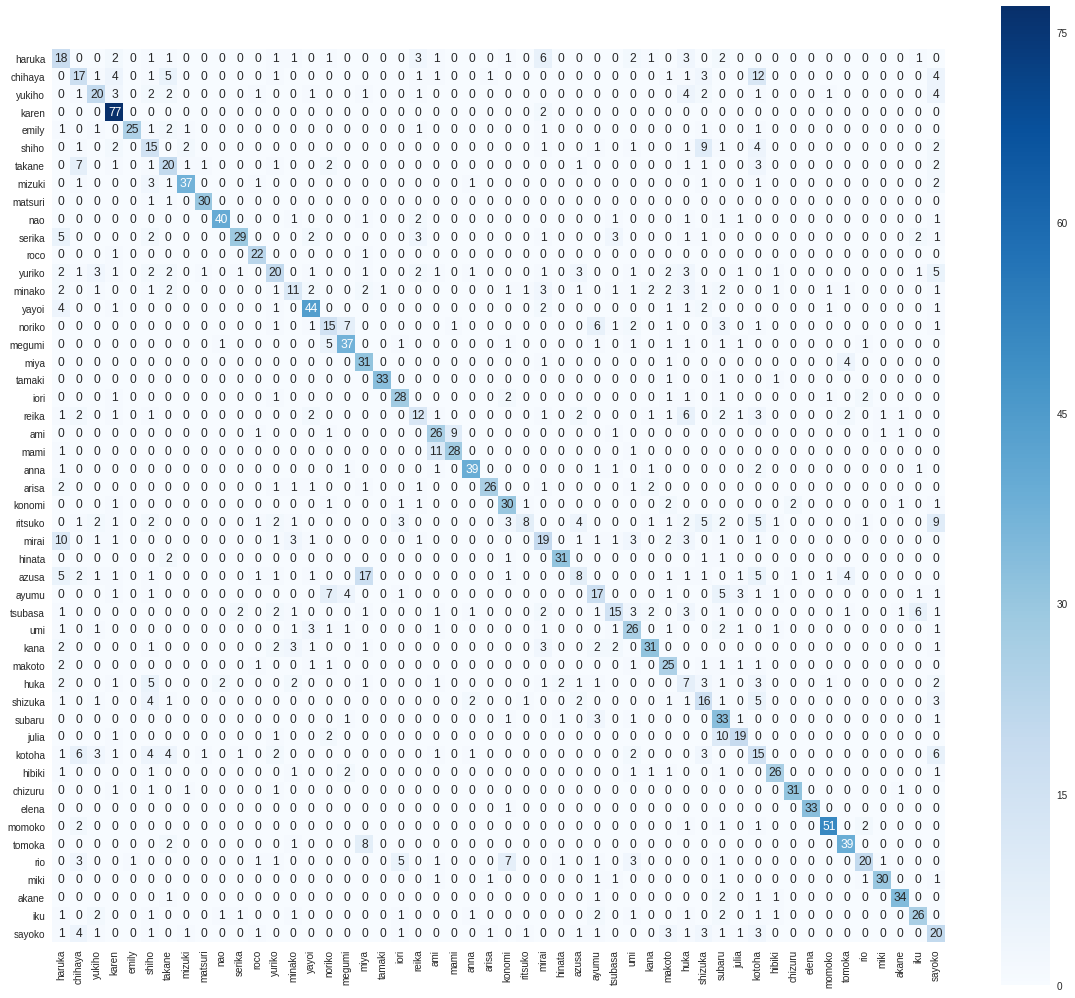

In [50]:
result_report(model, test_loader)

# Prediction

In [0]:
def string_to_codepoint(_str, max_length=max_length):
    _encoded_str = [ord(_x) for _x in str(_str).strip()]
    _encoded_str = _encoded_str[:max_length]
    _str_len = len(str(_str)) # String length
    if _str_len < max_length: # If string length is less than a num of max_length, do zero padding
        _encoded_str += ([0] * (max_length - _str_len))
    
    return _encoded_str

In [0]:
def predict(model, input_str):
    model = model.eval()
    with torch.no_grad():
        output = model(input_str)
    
    return output

In [51]:
encoded_str = torch.LongTensor(string_to_codepoint(input('Type a script:'))).unsqueeze(0).to(device)
#print(encoded_str.size())
result = predict(model, encoded_str)
res_df = pd.DataFrame(result.cpu().numpy())
res_df.rename(columns=idol_dict, index={0: 'likelihood'}, inplace=True)
res_df = res_df.T.sort_values('likelihood', ascending=False)
res_df

Type a script:さっき、シャボン玉を吹いてたんです。キラキラゆらゆら、楽しかったですよ♪キレイなのに、すぐにパチンと弾けちゃう。シャボン玉って、はかなくて切ないですね。  	likelihood


,likelihood
chihaya,0.142802
kotoha,0.123364
yayoi,0.073829
yukiho,0.052888
reika,0.052300
ritsuko,0.045509
shizuka,0.036941
emily,0.035429
azusa,0.035199
minako,0.030401
